In [56]:
import geopandas as gpd
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as d_gpd
import dask.distributed
from dask.diagnostics import ProgressBar
import shapely.geometry
import contextily as ctx
import numpy as np
import pandas as pd

In [3]:
pip install osmnx matplotlib-scalebar h3 -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import osmnx as ox
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
plt.style.use("dark_background")
mpl.rcParams['text.color'] = 'grey'


In [5]:
from shapely.geometry import Polygon, Point, JOIN_STYLE
from shapely.ops import unary_union
from shapely import wkt
import h3

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [12]:

# def update_environment():
#     import os
#     os.system("pip install h3")



In [13]:
# import dask_gateway

# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# # client.run(update_environment)
# cluster.adapt(minimum=2, maximum=50)

# print(cluster.dashboard_link)

In [7]:
import os

print(f"I have {os.cpu_count()} logical cores, counting hyperthreading.")

I have 8 logical cores, counting hyperthreading.


In [72]:
client = dask.distributed.Client(n_workers=10)
# client

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33841 instead
  warnings.warn(


In [9]:
country='Senegal' # the country yo uwant to access the data 

In [10]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": country}}
)
item = next(items.items())
asset=item.assets['data']
asset

In [11]:
# asset = item.assets["data"]

buildings_dask = d_gpd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
).to_crs(3857)
buildings_dask.head()

geometry RegionName   quadkey
0  POLYGON ((-1665512.705 1882321.840, -1665511.6...    Senegal  33301232
1  POLYGON ((-1665114.184 1879910.621, -1665109.4...    Senegal  33301232
2  POLYGON ((-1665323.062 1881048.451, -1665337.6...    Senegal  33301232
3  POLYGON ((-1665072.785 1879912.315, -1665066.7...    Senegal  33301232
4  POLYGON ((-1678156.166 1880093.416, -1678156.9...    Senegal  33301232

In [19]:
len(buildings_dask)

1848802

In [12]:
# read a shape fie to dask_geopandas
file = d_gpd.from_geopandas(gpd.read_file('commune_sn/LIMITE_COMMUNE_SENEGAL.shp'),npartitions=4).to_crs(3857)
file.head()

REG   DEPT    CAV                CCRCA COD_REG COD_DEPT COD_CAV  \
0  DAKAR  DAKAR  DAKAR            CAMBERENE      01        1     301   
1  DAKAR  DAKAR  DAKAR  PARCELLES ASSAINIES      01        1     301   
2  DAKAR  DAKAR  DAKAR          PATTE D'OIE      01        1     301   
3  DAKAR  DAKAR  DAKAR                 YOFF      01        1     301   
4  DAKAR  DAKAR  DAKAR                 NGOR      01        1     301   

  COD_CCRCA COD_ENTITE  SUPERFICIE       SUP_HA  LONGITUDE   LATITUDE  \
0        44   01130144    1.762112   176.211179 -17.429062  14.768523   
1        43   01130143    3.612295   361.229494 -17.442094  14.757746   
2        42   01130142    3.196803   319.680255 -17.441070  14.747620   
3        33   01130133   13.855895  1385.589548 -17.479905  14.747983   
4        32   01130132    4.350230   435.023028 -17.513376  14.744756   

         X_COORD       Y_COORD  \
0  238510.243444  1.634138e+06   
1  237093.617828  1.632960e+06   
2  237191.773466  1.631838e+06   
3  233008.886700  1.631924e+06   
4  229399.432902  1.631607e+06   

                                            geometry  
0  POLYGON ((-1939718.665 1663097.367, -1939698.5...  
1  POLYGON ((-1941671.953 1662409.429, -1941628.0...  
2  POLYGON ((-1939936.286 1660309.643, -1939907.5...  
3  POLYGON ((-1945348.404 1661873.704, -1945290.6...  
4  MULTIPOLYGON (((-1947935.339 1660977.516, -194...

In [13]:
from IPython.utils.text import columnize

In [14]:
def h3_poly(x,res=9):
    
    var = h3.geo_to_h3( x.y, x.x, res)

    return var

In [15]:
print(columnize(dir(shapely.geometry), displaywidth=100))


CAP_STYLE           MultiPolygon  __file__      asLinearRing       base             multipoint  
GeometryCollection  Point         __loader__    asMultiLineString  box              multipolygon
JOIN_STYLE          Polygon       __name__      asMultiPoint       collection       point       
LineString          __all__       __package__   asMultiPolygon     geo              polygon     
LinearRing          __builtins__  __path__      asPoint            linestring       proxy       
MultiLineString     __cached__    __spec__      asPolygon          mapping          shape       
MultiPoint          __doc__       asLineString  asShape            multilinestring  shapely     



In [24]:
# print(columnize(dir(d_gpd.GeoSeries), displaywidth=100))

In [16]:
h3_poly( shapely.geometry.Point(-14.96144,16.668920))

'89541535c27ffff'

In [17]:
buildings_dask['centroids']=(buildings_dask['geometry'].centroid.to_crs(4326))
buildings_dask['geo_h3'] = buildings_dask['centroids'].map(h3_poly, meta = ('', str))
# buildings_dask['geo_h3_copy'] = buildings_dask['centroids'].map(h3_poly, meta = ('', str))
# buildings_dask['counts']=buildings_dask.groupby('geo_h3_copy')['geo_h3'].transform(lambda x: x.astype(int).count())

buildings_dask.head()


geometry RegionName   quadkey  \
0  POLYGON ((-1665512.705 1882321.840, -1665511.6...    Senegal  33301232   
1  POLYGON ((-1665114.184 1879910.621, -1665109.4...    Senegal  33301232   
2  POLYGON ((-1665323.062 1881048.451, -1665337.6...    Senegal  33301232   
3  POLYGON ((-1665072.785 1879912.315, -1665066.7...    Senegal  33301232   
4  POLYGON ((-1678156.166 1880093.416, -1678156.9...    Senegal  33301232   

                    centroids           geo_h3  
0  POINT (-14.96144 16.66892)  89541535c27ffff  
1  POINT (-14.95791 16.64820)  895415359c7ffff  
2  POINT (-14.95992 16.65795)  895415358b7ffff  
3  POINT (-14.95759 16.64824)  895415359c7ffff  
4  POINT (-15.07516 16.64979)  89541520567ffff

In [27]:
# dir(h3)

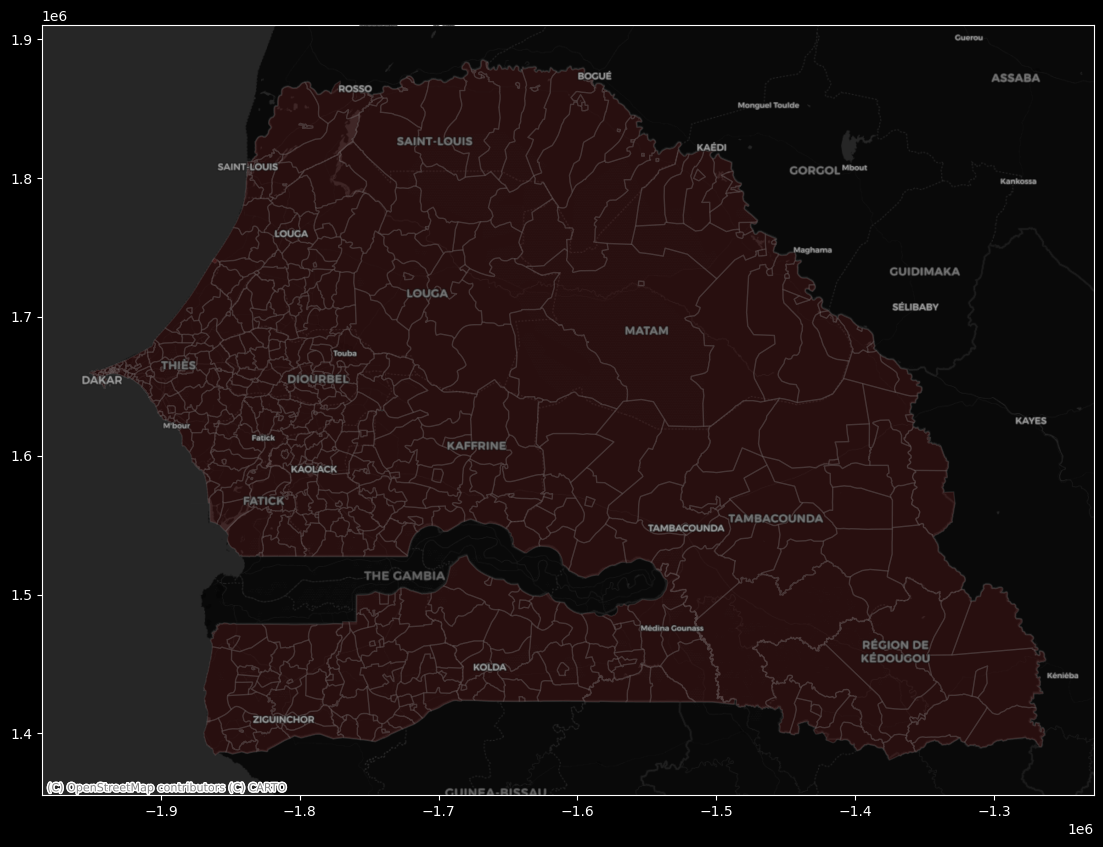

In [18]:
fig_=file.compute().plot(figsize=(14,10),alpha=0.2,edgecolor='grey',color='brown')

ctx.add_basemap(fig_, crs=file.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(fig_, crs=file.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

In [19]:
city_name='DAKAR'

#  query city from nominatim openstreetmap

# city=ox.geocode_to_gdf(city_name)

# query city from a file
city = file[file['DEPT'] == city_name.upper()]
city=city.to_crs(3857)
city.head()

REG   DEPT    CAV                CCRCA COD_REG COD_DEPT COD_CAV  \
0  DAKAR  DAKAR  DAKAR            CAMBERENE      01        1     301   
1  DAKAR  DAKAR  DAKAR  PARCELLES ASSAINIES      01        1     301   
2  DAKAR  DAKAR  DAKAR          PATTE D'OIE      01        1     301   
3  DAKAR  DAKAR  DAKAR                 YOFF      01        1     301   
4  DAKAR  DAKAR  DAKAR                 NGOR      01        1     301   

  COD_CCRCA COD_ENTITE  SUPERFICIE       SUP_HA  LONGITUDE   LATITUDE  \
0        44   01130144    1.762112   176.211179 -17.429062  14.768523   
1        43   01130143    3.612295   361.229494 -17.442094  14.757746   
2        42   01130142    3.196803   319.680255 -17.441070  14.747620   
3        33   01130133   13.855895  1385.589548 -17.479905  14.747983   
4        32   01130132    4.350230   435.023028 -17.513376  14.744756   

         X_COORD       Y_COORD  \
0  238510.243444  1.634138e+06   
1  237093.617828  1.632960e+06   
2  237191.773466  1.631838e+06   
3  233008.886700  1.631924e+06   
4  229399.432902  1.631607e+06   

                                            geometry  
0  POLYGON ((-1939718.665 1663097.367, -1939698.5...  
1  POLYGON ((-1941671.953 1662409.429, -1941628.0...  
2  POLYGON ((-1939936.286 1660309.643, -1939907.5...  
3  POLYGON ((-1945348.404 1661873.704, -1945290.6...  
4  MULTIPOLYGON (((-1947935.339 1660977.516, -194...

In [20]:
# other analysis
eps=3000
# city = (city['geometry'].agg(lambda x: unary_union(x).buffer(eps, 1, join_style=JOIN_STYLE.mitre).buffer(-eps, 1, join_style=JOIN_STYLE.mitre),))

city_buffer = city['geometry'].buffer(eps).unary_union         

city_buffer

dd.Scalar<unary_u..., type=BaseGeometry>

In [21]:
city_buffer = gpd.GeoSeries(city_buffer.compute())

In [32]:
city_buffer.head()

0    POLYGON ((-1944670.911 1648735.782, -1944681.2...
dtype: geometry

In [22]:
city_buffer = gpd.GeoDataFrame({'index': [0],'geometry':city_buffer}, crs="EPSG:3857")

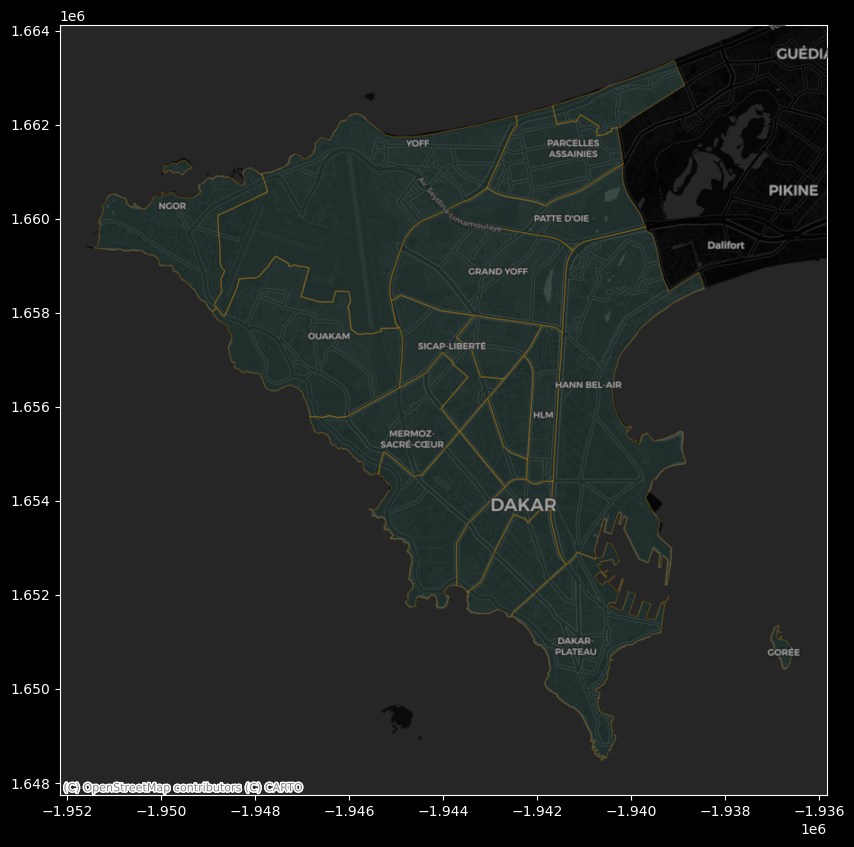

In [24]:
fig,ax=plt.subplots(figsize=(10,10))

my_city=city.compute()

my_city.plot(ax=ax,alpha=0.2,edgecolor='orange')

ctx.add_basemap(ax=ax, crs=my_city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
ctx.add_basemap(ax=ax, crs=my_city.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)

# ctx.add_basemap(figure, crs=city.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

In [36]:
# ax = df_dask.plot(figsize=(12, 12), color="red")
# contextily.add_basemap(
#     ax, source=contextily.providers.CartoDB.DarkMatterNoLabels, crs=df_dask.crs.to_string()
# )
# ax.set_axis_off()

In [25]:
building_in_city=d_gpd.sjoin(buildings_dask,city_buffer , how='inner')

In [28]:
    
buildings_=building_in_city.compute()


In [29]:
buildings_.drop(['index_right','index'], axis=1, inplace=True)

In [30]:
buildings=buildings_.reset_index()

In [31]:
buildings.head()

index                                           geometry RegionName  \
0      0  POLYGON ((-1944139.820 1655667.220, -1944163.1...    Senegal   
1      1  POLYGON ((-1941969.061 1651660.266, -1941964.9...    Senegal   
2      2  POLYGON ((-1941553.048 1650113.602, -1941548.0...    Senegal   
3      3  POLYGON ((-1936815.311 1660067.366, -1936851.1...    Senegal   
4      6  POLYGON ((-1945329.461 1660530.519, -1945324.8...    Senegal   

    quadkey                   centroids           geo_h3  
0  33302131  POINT (-17.46461 14.70876)  8954ac2ee4bffff  
1  33302131  POINT (-17.44497 14.67402)  8954ac2eb47ffff  
2  33302131  POINT (-17.44133 14.66068)  8954ac2cd8bffff  
3  33302131  POINT (-17.39898 14.74702)  8954ac250bbffff  
4  33302131  POINT (-17.47523 14.75127)  8954ac2e637ffff

In [44]:
buildings=buildings.set_index(['index'])

In [32]:
buildings.head()

index                                           geometry RegionName  \
0      0  POLYGON ((-1944139.820 1655667.220, -1944163.1...    Senegal   
1      1  POLYGON ((-1941969.061 1651660.266, -1941964.9...    Senegal   
2      2  POLYGON ((-1941553.048 1650113.602, -1941548.0...    Senegal   
3      3  POLYGON ((-1936815.311 1660067.366, -1936851.1...    Senegal   
4      6  POLYGON ((-1945329.461 1660530.519, -1945324.8...    Senegal   

    quadkey                   centroids           geo_h3  
0  33302131  POINT (-17.46461 14.70876)  8954ac2ee4bffff  
1  33302131  POINT (-17.44497 14.67402)  8954ac2eb47ffff  
2  33302131  POINT (-17.44133 14.66068)  8954ac2cd8bffff  
3  33302131  POINT (-17.39898 14.74702)  8954ac250bbffff  
4  33302131  POINT (-17.47523 14.75127)  8954ac2e637ffff

In [46]:
# buildings=d_gpd.from_geopandas(buildings,npartitions=4)

In [33]:

buildings['counts']=buildings.groupby('geo_h3')['geo_h3'].transform(lambda x: x.count())


In [34]:
buildings['areas']=buildings.geometry.area

In [35]:
buildings[['counts','areas']].head()

counts        areas
0     207   389.309329
1     147    26.026320
2      48   388.282414
3     119  1873.359773
4     108  1169.125743

In [36]:
em = h3.hex_area(resolution=9,unit='m^2')
em

105332.5

In [37]:
 # h3.hex_area?

In [38]:
buildings['buildings_area'] = buildings.groupby('geo_h3')['areas'].transform(lambda x: x.sum())

In [39]:
buildings['scale']=(buildings['buildings_area']/em)

In [54]:
# buildings['scale']=buildings['scale_']/(buildings['scale_'].sum())

In [40]:
buildings['scale'].max(),buildings['scale'].min()

(0.6088908886894138, 0.0001939965809353196)

In [41]:
buildings.head()

index                                           geometry RegionName  \
0      0  POLYGON ((-1944139.820 1655667.220, -1944163.1...    Senegal   
1      1  POLYGON ((-1941969.061 1651660.266, -1941964.9...    Senegal   
2      2  POLYGON ((-1941553.048 1650113.602, -1941548.0...    Senegal   
3      3  POLYGON ((-1936815.311 1660067.366, -1936851.1...    Senegal   
4      6  POLYGON ((-1945329.461 1660530.519, -1945324.8...    Senegal   

    quadkey                   centroids           geo_h3  counts        areas  \
0  33302131  POINT (-17.46461 14.70876)  8954ac2ee4bffff     207   389.309329   
1  33302131  POINT (-17.44497 14.67402)  8954ac2eb47ffff     147    26.026320   
2  33302131  POINT (-17.44133 14.66068)  8954ac2cd8bffff      48   388.282414   
3  33302131  POINT (-17.39898 14.74702)  8954ac250bbffff     119  1873.359773   
4  33302131  POINT (-17.47523 14.75127)  8954ac2e637ffff     108  1169.125743   

   buildings_area     scale  
0    37670.206263  0.357631  
1    33955.998977  0.322370  
2    17329.051560  0.164518  
3    28680.732007  0.272288  
4    31783.927261  0.301749

In [42]:

buildings=gpd.sjoin(buildings,city.compute() , how='inner')


In [58]:
# import fiona

In [43]:
buildings___=buildings.reset_index()

In [44]:
mu, sigma = 12, 4 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000000)

In [45]:
s_ = np.random.choice(s[s>4],77388) #sampling the buildings' height

In [63]:
s_

array([11.6633859 , 13.74582326, 11.31264966, ..., 17.75712464,
       10.24537224,  8.11261627])

In [46]:
buildings['height']=s_

In [ ]:
buildings

In [47]:
buildings[['geometry','areas','CCRCA','height']].to_crs(4326).to_file('buildings_shapefile/building_dakar.geojson', driver='GeoJSON')

In [68]:
def plot_map(gdf,metric_col,city_name,cmap_='rainbow'):
    
    fig,ax=plt.subplots(1,1,figsize =(16,20),facecolor='black')

    ax.set_facecolor('grey')



    divider = make_axes_locatable(ax)

    cax = divider.append_axes("bottom", size="2%", pad=0.2)

    # city.plot(ax=ax,alpha=.7,color='none',edgecolor = 'orange',aspect=1)  

    gdf.plot(ax=ax,alpha=.6,cmap=cmap_,
                   legend=True,
                   column=gdf[metric_col],
                   legend_kwds={'label': "buildings density",
                            'orientation': "horizontal"},cax=cax,aspect=1)

    # ax.legend(labelcolor='w')
    # cx.add_basemap(figu,crs=km.crs,source=cx.providers.Stamen.TonerLite)

    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterNoLabels)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.DarkMatterOnlyLabels)



    # North arrow
    x, y, arrow_length = 0.97, 0.98, 0.07
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length*1.25),
                arrowprops=dict(facecolor='whitesmoke', width=7, headwidth=18,edgecolor='brown'),
                ha='center', va='center', fontsize=22,color='whitesmoke',
                xycoords=ax.transAxes)
    ax.add_artist(ScaleBar(6,box_alpha = 0,location='lower right',color='whitesmoke'))


    # ax.tick_params(labelcolor='tab:orange',labelsize=15)

    ax.set_axis_off()



    # ax.text(0.1,0.3,'DAKAR',fontsize=70,color='grey',transform=ax.transAxes,style='italic')
    # ax.text(0.135,0.27,'SENEGAL',fontsize=35,color='grey',transform=ax.transAxes,style='italic')
    ax.text(0.45,0.02,'sowelhaz@gmail.com',fontsize=14,color='grey',transform=ax.transAxes)

    # plt.savefig(f'{city_name}.png',dpi=250)

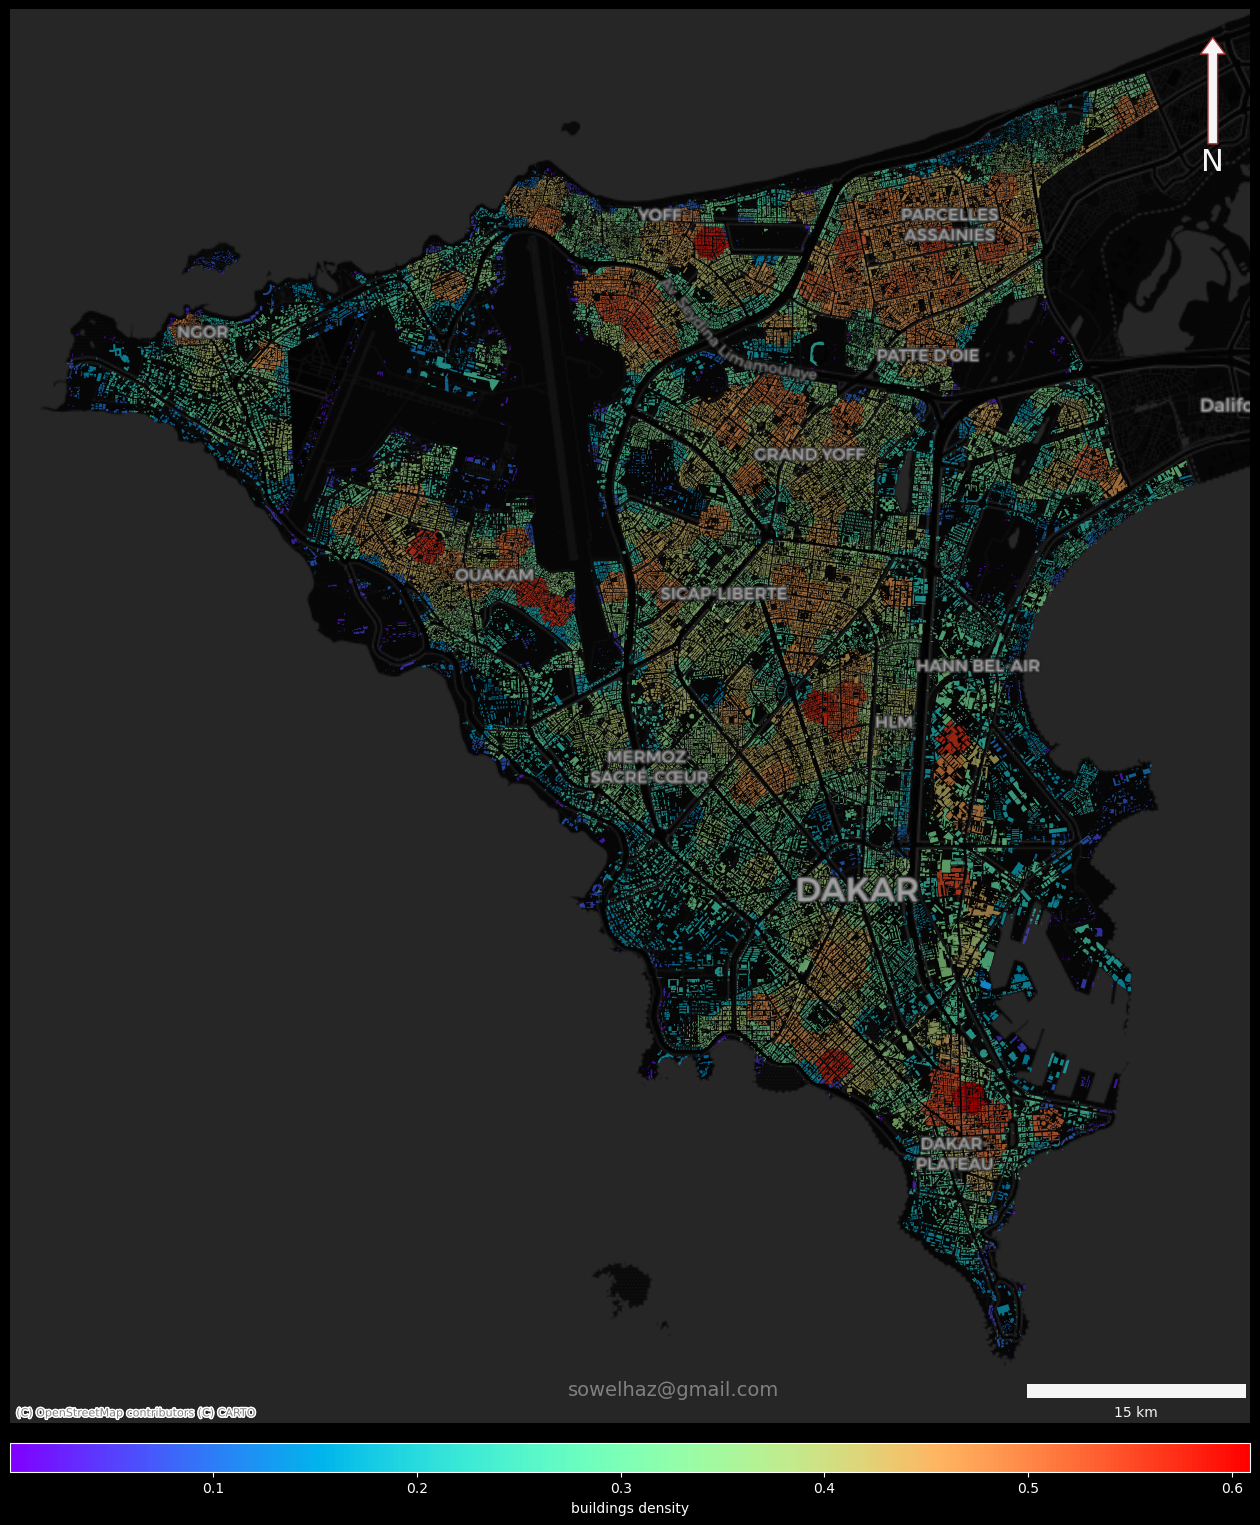

In [60]:
plot_map(buildings,'scale','Dept_Dakar')

# Spatial smoothing

In [65]:
def spatial_smoothing(gdf, geo_h3, metric_col, kn):
    gdf_k = gdf[[geo_h3]] 
    gdf_k.index = gdf_k[geo_h3]
    gdf_s =  (gdf_k[geo_h3]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,kn)))).stack()
                 .to_frame('h3_k').reset_index(1, drop=True).reset_index()
                 .merge(gdf[[geo_h3,metric_col]]).fillna(0)
                 .groupby(['h3_k'])[[metric_col]].sum().divide((1 + 3 * kn * (kn + 1))) # number_of_rings = 1 + 6*Sum_from_1_to_N_of(kn)  
                 .reset_index()
                 .rename(index=str, columns={"h3_k": geo_h3}))
    gdf_s['lat'] = gdf_s[geo_h3].apply(lambda x: h3.h3_to_geo(x)[0])
    gdf_s['long'] = gdf_s[geo_h3].apply(lambda x: h3.h3_to_geo(x)[1])
    gdf_s['geometry']=gpd.points_from_xy(x=gdf_s.long,y=gdf_s.lat,crs=4326)
    gdf_s=gpd.GeoDataFrame( gdf_s, geometry=gdf_s['geometry'])
    return gdf_s.to_crs(3857)

In [49]:
# aggregate the polygons
dfg = building_in_city.groupby('geo_h3').size().to_frame('counts').reset_index()




In [50]:
#find center of hex for visualization
dfg['lat'] = dfg['geo_h3'].map(lambda x: h3.h3_to_geo(x)[0],meta=('',str))
dfg['lng'] = dfg['geo_h3'].map(lambda x: h3.h3_to_geo(x)[1],meta=('',str))

In [51]:
dfg=dfg.compute()

In [52]:
dfg.head()

geo_h3  counts        lat        lng
0  8954ac20923ffff     159  14.773030 -17.413889
1  8954ac20927ffff     234  14.771174 -17.411372
2  8954ac2092bffff     144  14.771888 -17.416997
3  8954ac2092fffff     210  14.770032 -17.414481
4  8954ac20933ffff      53  14.776028 -17.413297

In [66]:
building_kriging = spatial_smoothing(dfg,'geo_h3','counts',2)

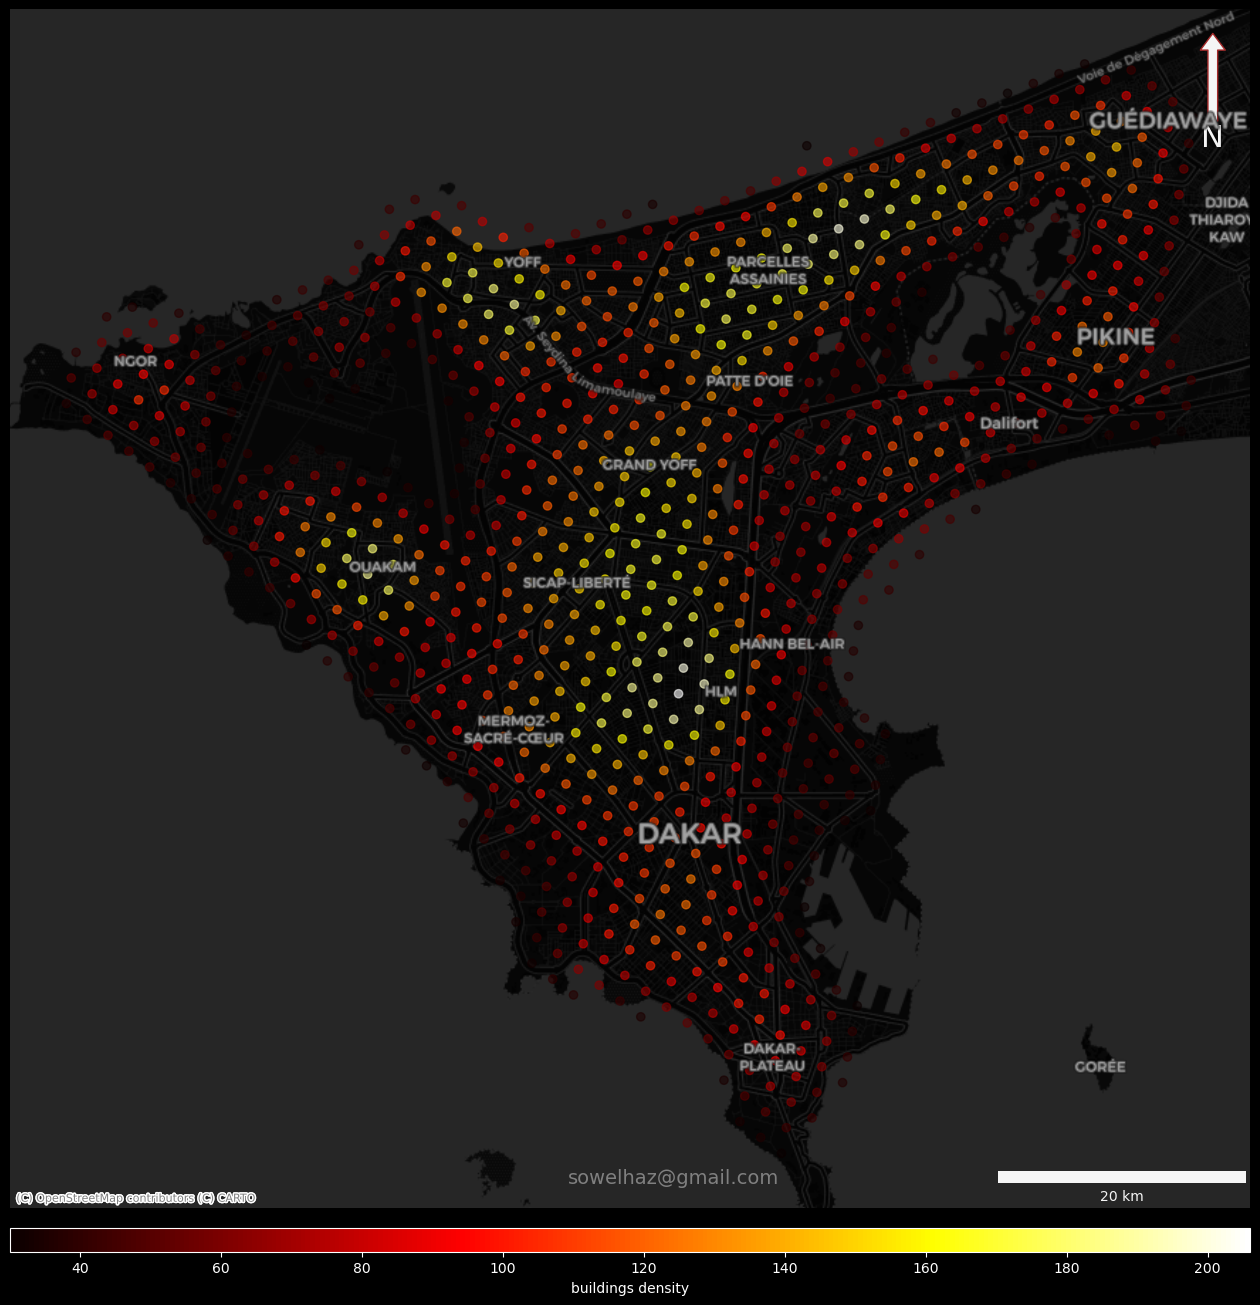

In [69]:
plot_map(building_kriging[building_kriging.counts>30],metric_col='counts',city_name='Dakar_smooth',cmap_='hot')

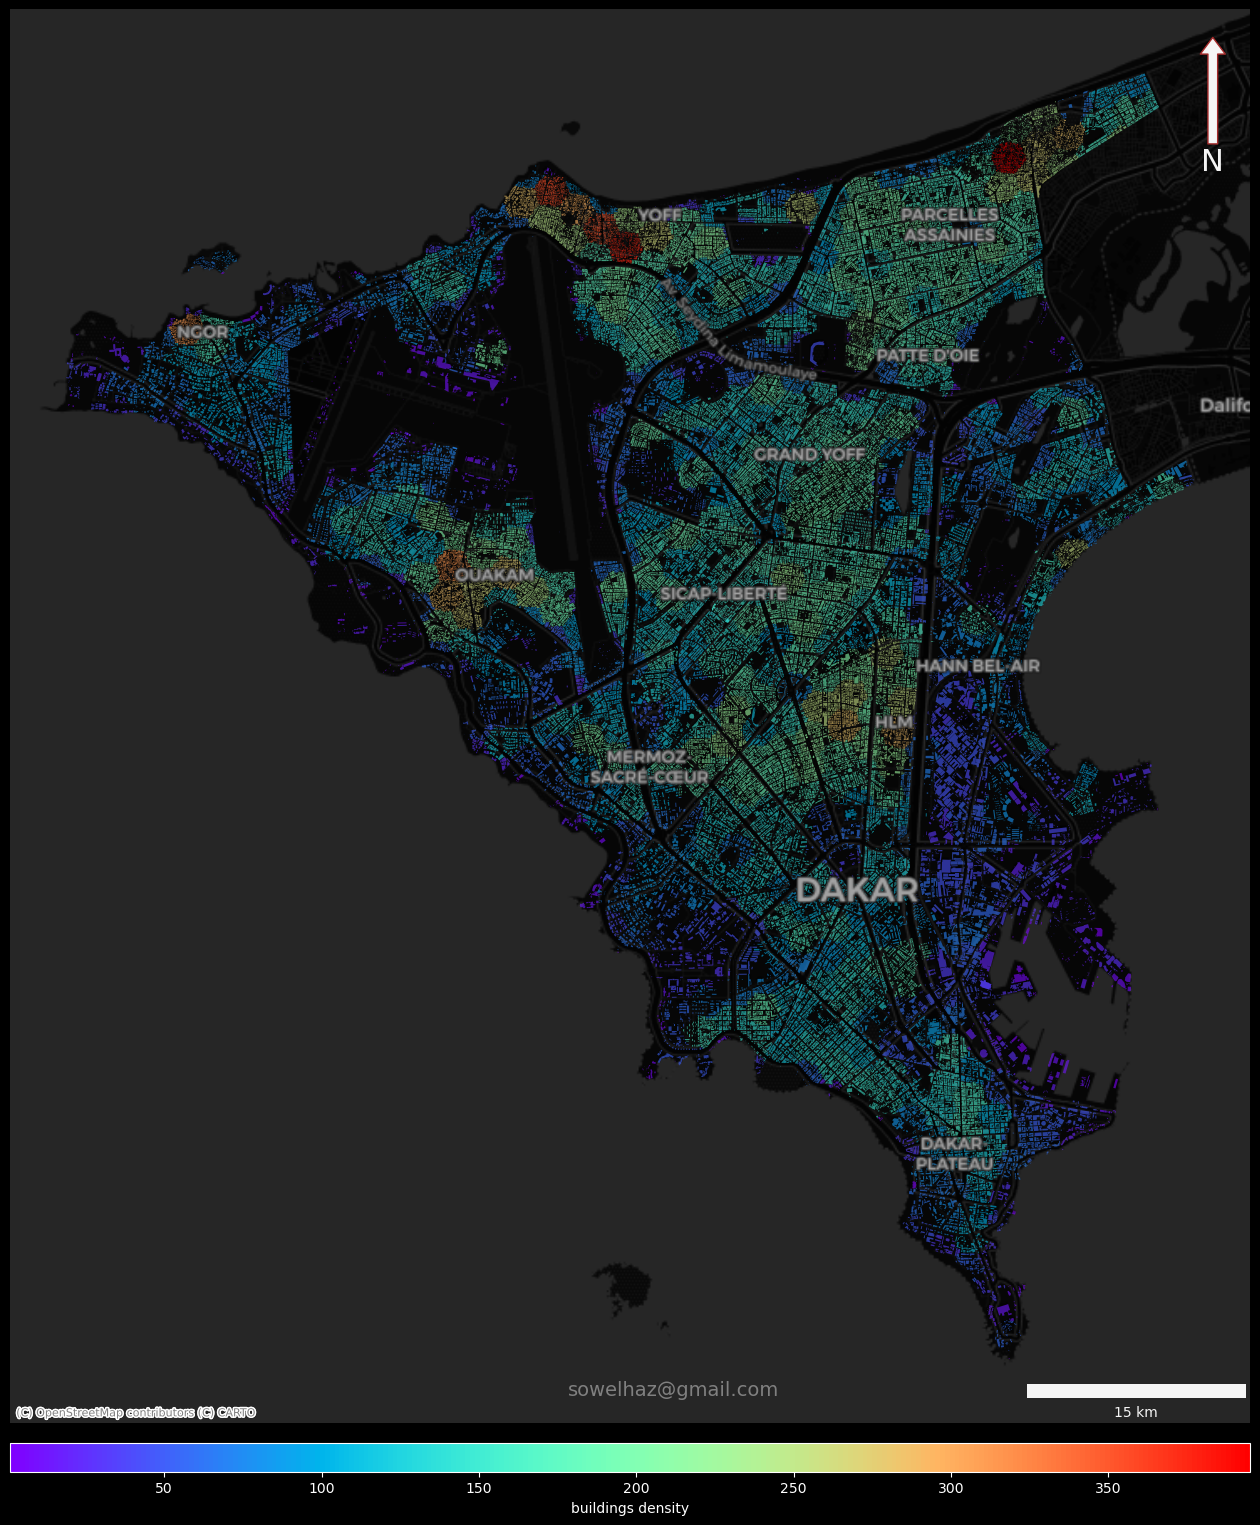

In [70]:
plot_map(buildings,'counts','Dept_Dakar')

In [71]:
print(columnize(dir(gpd.points_from_xy), displaywidth=100))

__annotations__  __defaults__  __format__        __hash__           __module__    __reduce_ex__   
__builtins__     __delattr__   __ge__            __init__           __name__      __repr__        
__call__         __dict__      __get__           __init_subclass__  __ne__        __setattr__     
__class__        __dir__       __getattribute__  __kwdefaults__     __new__       __sizeof__      
__closure__      __doc__       __globals__       __le__             __qualname__  __str__         
__code__         __eq__        __gt__            __lt__             __reduce__    __subclasshook__

